In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os
from scipy import stats
import scipy
from sklearn.metrics import r2_score

#ignoring warnings
import warnings
warnings.filterwarnings('ignore')

# Import raw data 

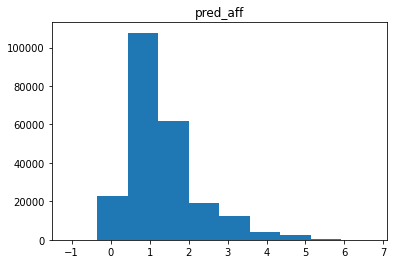

Total number of interactions
527601
Interactions with affinity measurements
230042
Unique MATas
71
Unique MATalphas
2477


In [3]:

#Import raw AlphaSeq data
df0=pd.read_csv('./raw_data/Supplementary_Table4_CoV_SSM_RawData.csv')

#plot distribution of affinity values
plt.hist(df0.pred_aff,bins=10)
plt.title('pred_aff')
plt.show()

print('Total number of interactions')
print(len(df0))
print('Interactions with affinity measurements')
print(len(df0[df0.pred_aff > 0]))
print('Unique MATas')
print(len(df0.mata_description.unique()))
print('Unique MATalphas')
print(len(df0.matalpha_description.unique()))

In [4]:
df0

Unnamed: 0  Unnamed: 0.1  mata_description matalpha_description  \
0                0             0     CoV_binder_31            V165Q_CAA   
1                1             1  CoV_binder_13_LH             S55K_AAA   
2                2             2     CoV_binder_31            L199G_GGT   
3                3             3     CoV_binder_31             S55N_AAT   
4                4             4     CoV_binder_31             V49W_TGG   
...            ...           ...               ...                  ...   
527596      527596        535027  CoV_binder_19_HL            G128P_CCA   
527597      527597        535028  CoV_binder_19_HL            G128M_ATG   
527598      527598        535029  CoV_binder_19_HL            G128L_TTG   
527599      527599        535030  CoV_binder_19_HL            G128K_AAA   
527600      527600        535031      m396_scFv_LH                aBFL1   

        pred_aff  sample_name  
0       0.406877            1  
1       0.414853            1  
2       0.381744            1  
3       0.235948            1  
4       0.342527            1  
...          ...          ...  
527596       NaN            3  
527597       NaN            3  
527598       NaN            3  
527599       NaN            3  
527600       NaN            3  

[527601 rows x 6 columns]

# Data processing 

In [5]:
df0['interaction'] = df0.mata_description + '$' + df0.matalpha_description 

df=df0.pivot(index='interaction', columns='sample_name', values='pred_aff').reset_index()

df[['mata_description','matalpha_description']] = df.interaction.str.split(expand=True,pat='$') 

df['aff_mean']= df[[1,2,3]].mean(axis=1)
df['aff_std']= df[[1,2,3]].std(axis=1)
df['aff_cv']= np.abs(df.aff_std / df.aff_mean)

df['aff_1_nm']= np.power(10,df[1])
df['aff_2_nm']= np.power(10,df[2])
df['aff_3_nm']= np.power(10,df[3])

df['aff_mean_nm']= df[['aff_1_nm','aff_2_nm','aff_3_nm']].mean(axis=1)
df['aff_std_nm']= df[['aff_1_nm','aff_2_nm','aff_3_nm']].std(axis=1)
df['aff_cv_nm']= np.abs(df.aff_std_nm / df.aff_mean_nm) *100

df=df.sort_values(by='aff_mean')

#Removing observations not seen in all replicates to create quantitative dataset
dfquant=df[~((np.isnan(df[1])) | (np.isnan(df[2])) | (np.isnan(df[3])))]

#Creating dataframe for WT interactiions
dfwtpass=((dfquant[dfquant.matalpha_description.str.contains('SARS-CoV2_RBD')]))

################################################
#Operations to deal with SSM data
################################################

#to remove codon from matalpha description
df.matalpha_description = df.matalpha_description.str.split(expand=True,pat='_')

#to break down 
df[['wt','pos','mut']] = df.matalpha_description.str.extract('^([a-zA-Z]+)(\d+)([a-zA-Z]+)$')
df.pos = pd.to_numeric(df.pos)

#adding offset to SSM position
df.pos = df.pos + 318

In [6]:
print('How many positions?')
print(len(df.pos.dropna().unique()))

print('How many substitutions per site?')
print(len(df.mut.dropna().unique()))

How many positions?
165
How many substitutions per site?
19


In [7]:
print('Total proteins in MatAlpha library mapped')
print(len(df0.matalpha_description.unique()))
print('Total proteins in MatAlpha library from the SSM')
print(len(df.matalpha_description.unique()))

Total proteins in MatAlpha library mapped
2477
Total proteins in MatAlpha library from the SSM
2443


# Merging dataframe with antibody full names

In [8]:
names = pd.read_csv('./raw_data/Supplementary_Table6_AntibodiesNameFormats.csv')
names['Short_Name']=names.Short_Name + '_HL'

names2 = pd.read_csv('./raw_data/Supplementary_Table6_AntibodiesNameFormats.csv')
names2['Short_Name']=names2.Short_Name + '_LH'

names3 = pd.read_csv('./raw_data/Supplementary_Table6_AntibodiesNameFormats.csv')
names3['Short_Name']=names3.Short_Name

names4 = pd.concat([names,names2,names3])
names4.append(pd.DataFrame([['ACE2','ACE2']], columns=['Name','Short_Name']))

df=pd.merge(df,names4,left_on='mata_description',right_on='Short_Name',how='outer').reset_index(drop=True)
df=df.dropna(subset=['mata_description'])

df['binderno']=pd.to_numeric(df.mata_description.str.extract(r'(?:binder_)(\d+)').iloc[:,0])

In [9]:
#Adding orientation LH HL to antibody name
df["ori"] = " "
df["ori"][df['mata_description'].str.contains("LH")] = "_LH"
df["ori"][df['mata_description'].str.contains("HL")] = "_HL"
df['Name&Ori'] = df.Name + df.ori
df.head()

interaction   1         2         3 mata_description  \
0  CoV_binder_6_LH$N142H_CAT NaN -1.117423       NaN  CoV_binder_6_LH   
1   CoV_binder_6_LH$G95T_ACT NaN -0.258673       NaN  CoV_binder_6_LH   
2  CoV_binder_6_LH$Y187E_GAA NaN -0.114637       NaN  CoV_binder_6_LH   
3   CoV_binder_6_LH$S53K_AAA NaN       NaN  0.041594  CoV_binder_6_LH   
4   CoV_binder_6_LH$F20M_ATG NaN  0.065080       NaN  CoV_binder_6_LH   

  matalpha_description  aff_mean  aff_std  aff_cv  aff_1_nm  ...  aff_cv_nm  \
0                N142H -1.117423      NaN     NaN       NaN  ...        NaN   
1                 G95T -0.258673      NaN     NaN       NaN  ...        NaN   
2                Y187E -0.114637      NaN     NaN       NaN  ...        NaN   
3                 S53K  0.041594      NaN     NaN       NaN  ...        NaN   
4                 F20M  0.065080      NaN     NaN       NaN  ...        NaN   

   wt    pos  mut       Short_Name         Name  \
0   N  460.0    H  CoV_binder_6_LH  Tixagevimab   
1   G  413.0    T  CoV_binder_6_LH  Tixagevimab   
2   Y  505.0    E  CoV_binder_6_LH  Tixagevimab   
3   S  371.0    K  CoV_binder_6_LH  Tixagevimab   
4   F  338.0    M  CoV_binder_6_LH  Tixagevimab   

                          Name_extra binderno  ori        Name&Ori  
0  Tixagevimab / AZD8895 / COV2-2196      6.0  _LH  Tixagevimab_LH  
1  Tixagevimab / AZD8895 / COV2-2196      6.0  _LH  Tixagevimab_LH  
2  Tixagevimab / AZD8895 / COV2-2196      6.0  _LH  Tixagevimab_LH  
3  Tixagevimab / AZD8895 / COV2-2196      6.0  _LH  Tixagevimab_LH  
4  Tixagevimab / AZD8895 / COV2-2196      6.0  _LH  Tixagevimab_LH  

[5 rows x 24 columns]

# Determining WT binding

In [10]:
#Mergining WT binding dataframe with antibodies names taable
dfwt1=pd.merge(dfwtpass,names4,left_on='mata_description',
               right_on='Short_Name',how='outer').reset_index(drop=True)

#Only selecting those antibodies with measurements in three replicates
dfwt1=dfwt1.dropna()

#Combining names and scfv's orientations
dfwt1["ori"] = " "
dfwt1["ori"][dfwt1['mata_description'].str.contains("LH")] = "_LH"
dfwt1["ori"][dfwt1['mata_description'].str.contains("HL")] = "_HL"
dfwt1['Name&Ori'] = dfwt1.Name + dfwt1.ori
dfwt1=dfwt1.dropna()
dfwt1

interaction         1         2         3  \
1      CoV_binder_31$SARS-CoV2_RBD  0.661909  0.667772  0.660220   
2      CoV_binder_29$SARS-CoV2_RBD  0.752373  0.705172  0.584149   
3   CoV_binder_13_LH$SARS-CoV2_RBD  0.744150  0.717734  0.758482   
4      CoV_binder_28$SARS-CoV2_RBD  0.777186  0.758088  0.853792   
5   CoV_binder_10_HL$SARS-CoV2_RBD  0.866695  0.816874  0.912354   
6    CoV_binder_4_HL$SARS-CoV2_RBD  0.854771  0.874847  1.002582   
7   CoV_binder_13_HL$SARS-CoV2_RBD  1.135634  1.025323  1.095447   
8    CoV_binder_4_LH$SARS-CoV2_RBD  1.137726  1.005612  1.151873   
9   CoV_binder_11_HL$SARS-CoV2_RBD  1.237859  1.128313  0.989718   
10  CoV_binder_10_LH$SARS-CoV2_RBD  1.219201  1.050552  1.172905   
11   CoV_binder_9_LH$SARS-CoV2_RBD  1.122375  1.208154  1.262678   
12   CoV_binder_3_HL$SARS-CoV2_RBD  1.299401  1.136106  1.248004   
13   CoV_binder_8_LH$SARS-CoV2_RBD  1.357277  1.204507  1.130874   
14  CoV_binder_22_LH$SARS-CoV2_RBD  1.323023  1.399427  1.134887   
15   CoV_binder_2_LH$SARS-CoV2_RBD  1.402273  1.317943  1.232725   
16  CoV_binder_11_LH$SARS-CoV2_RBD  1.424922  1.318701  1.345372   
17   CoV_binder_8_HL$SARS-CoV2_RBD  1.502915  1.244549  1.529700   
19  CoV_binder_21_LH$SARS-CoV2_RBD  1.556303  1.575251  1.448530   
20  CoV_binder_17_HL$SARS-CoV2_RBD  1.871222  1.511643  1.352078   
21   CoV_binder_9_HL$SARS-CoV2_RBD  1.916286  1.649330  1.408477   
22   CoV_binder_3_LH$SARS-CoV2_RBD  1.802102  1.504562  1.690391   
23  CoV_binder_22_HL$SARS-CoV2_RBD  1.685928  1.693149  1.656204   
24   CoV_binder_6_LH$SARS-CoV2_RBD  1.593521  1.807553  1.663186   
25  CoV_binder_18_HL$SARS-CoV2_RBD  1.679075  1.738902  1.647700   
26  CoV_binder_24_LH$SARS-CoV2_RBD  1.692623  1.785894  1.630349   
27  CoV_binder_18_LH$SARS-CoV2_RBD  1.744777  1.579675  1.965465   
28  CoV_binder_21_HL$SARS-CoV2_RBD  1.618323  2.136704  1.561236   
29  CoV_binder_17_LH$SARS-CoV2_RBD  1.864439  1.819287  1.714005   
30  CoV_binder_16_LH$SARS-CoV2_RBD  1.956873  1.694007  1.880956   
31  CoV_binder_24_HL$SARS-CoV2_RBD  1.825711  1.929997  1.853283   
32  CoV_binder_15_LH$SARS-CoV2_RBD  2.362288  1.928349  1.806758   
33  CoV_binder_25_HL$SARS-CoV2_RBD  2.000722  2.065327  2.037912   
34   CoV_binder_1_LH$SARS-CoV2_RBD  2.443584  1.720544  2.017512   
35  CoV_binder_14_LH$SARS-CoV2_RBD  1.879361  2.118604  2.216159   
36  CoV_binder_26_LH$SARS-CoV2_RBD  2.127790  2.013467  2.130574   
37   CoV_binder_5_HL$SARS-CoV2_RBD  2.121290  2.142938  2.064379   
38  CoV_binder_19_LH$SARS-CoV2_RBD  2.272273  2.018500  2.067440   
39   CoV_binder_2_HL$SARS-CoV2_RBD  2.250858  2.152773  2.033458   
40   CoV_binder_7_LH$SARS-CoV2_RBD  2.168964  2.061759  2.212452   
41  CoV_binder_14_HL$SARS-CoV2_RBD  2.406728  2.259906  1.816907   
42  CoV_binder_20_LH$SARS-CoV2_RBD  2.688950  2.260984  2.156303   
43  CoV_binder_23_LH$SARS-CoV2_RBD  2.155037  2.509564  2.636067   
44  CoV_binder_20_HL$SARS-CoV2_RBD  2.697572  2.311246  2.323783   
45  CoV_binder_27_HL$SARS-CoV2_RBD  3.047142  2.342818  1.994789   
46     CoV_binder_32$SARS-CoV2_RBD  2.229755  2.248738  2.944845   
47     CoV_binder_30$SARS-CoV2_RBD  2.429126  2.412849  3.024674   
48  CoV_binder_25_LH$SARS-CoV2_RBD  2.958252  2.352916  2.656699   
49  CoV_binder_26_HL$SARS-CoV2_RBD  2.432117  2.959087  2.662582   
50  CoV_binder_27_LH$SARS-CoV2_RBD  2.714406  1.955924  3.682368   
51  CoV_binder_19_HL$SARS-CoV2_RBD  2.933822  3.473023  2.184963   
52   CoV_binder_5_LH$SARS-CoV2_RBD  3.204644  3.502682  3.003433   
53  CoV_binder_12_LH$SARS-CoV2_RBD  3.554865  2.780124  3.728624   

    mata_description matalpha_description  aff_mean   aff_std    aff_cv  \
1      CoV_binder_31        SARS-CoV2_RBD  0.663301  0.003964  0.005975   
2      CoV_binder_29        SARS-CoV2_RBD  0.680565  0.086770  0.127497   
3   CoV_binder_13_LH        SARS-CoV2_RBD  0.740122  0.020671  0.027929   
4      CoV_binder_28        SARS-CoV2_RBD  0.796355  0.050650  0.063602   
5   CoV_binder_10_HL        SARS-CoV2_RBD  

In [11]:
# # # # Added code

import regex as re

#Import curated table with experimental data

exp_data = pd.read_csv('./raw_data/aalpha_bio_RBD_sequence_data_raw.csv')

exp_data = exp_data.iloc[: , 1:]
exp_data_list = exp_data.values.tolist()


dfwt1_list = dfwt1.values.tolist()
final_data = []
final_data_dfwt1 = []
best_correlation_list = []

for n in exp_data_list:
    dist_val = []
    final_data_dfwt1_temp = []
    for t in dfwt1_list:
        if '_LH' in t[4] or '_HL' in t[4]:
            name_seq = t[4][0:len(t[4])-3]
        else:
            name_seq = t[4]
        rank = int(re.findall(r'\d+',name_seq)[0])
        if name_seq == n[0]:
            name_from_list = t[4]
            aff_mean_nm = t[6]
            aff_std_nm = t[7]
            dist_val.append([abs(float(aff_mean_nm)-float(np.log10(n[9])))])
            final_data.append([n[0],name_from_list,aff_mean_nm,aff_std_nm, t[1], t[2], t[3]])
            final_data_dfwt1_temp.append([name_from_list,n[9],np.log10(n[9]), rank,n[13]]) 
            final_data_dfwt1.append([name_from_list,n[9],np.log10(n[9]), rank,n[13]])
    if len(dist_val) > 0: 
        min_index = dist_val.index(min(dist_val))
        best_correlation_list.append(final_data_dfwt1_temp[min_index])

prede_aalpha = pd.DataFrame(final_data)
prede_aalpha.columns =['Short_Name','name_alpha_bio','alpha_bio_pred_affinity_mean_log10_KD', 'alpha_bio_pred_std', 'alpha_bio_pred_measurement_1', 'alpha_bio_pred_measurement_2','alpha_bio_pred_measurement_3']

prede_aalpha_dfwt1 = pd.DataFrame(final_data_dfwt1)
prede_aalpha_dfwt1.columns =['mata_description','experimental_KD_nM','experimental_KD_nM_log10', 'rank', 'format']

prede_aalpha_dfwt1_best = pd.DataFrame(best_correlation_list)
prede_aalpha_dfwt1_best.columns =['mata_description','experimental_KD_nM','experimental_KD_nM_log10', 'rank', 'format']

aalpha_data_all =  (pd.merge(exp_data, prede_aalpha , on='Short_Name'))

dfwt1_1 = (pd.merge(dfwt1, prede_aalpha_dfwt1, on='mata_description'))

dfwt1_best = (pd.merge(dfwt1, prede_aalpha_dfwt1_best, on='mata_description'))

aalpha_data_all.to_csv('./output/aalpha_bio_RBD_sequence_data_processed_epitope_data_nt.csv')

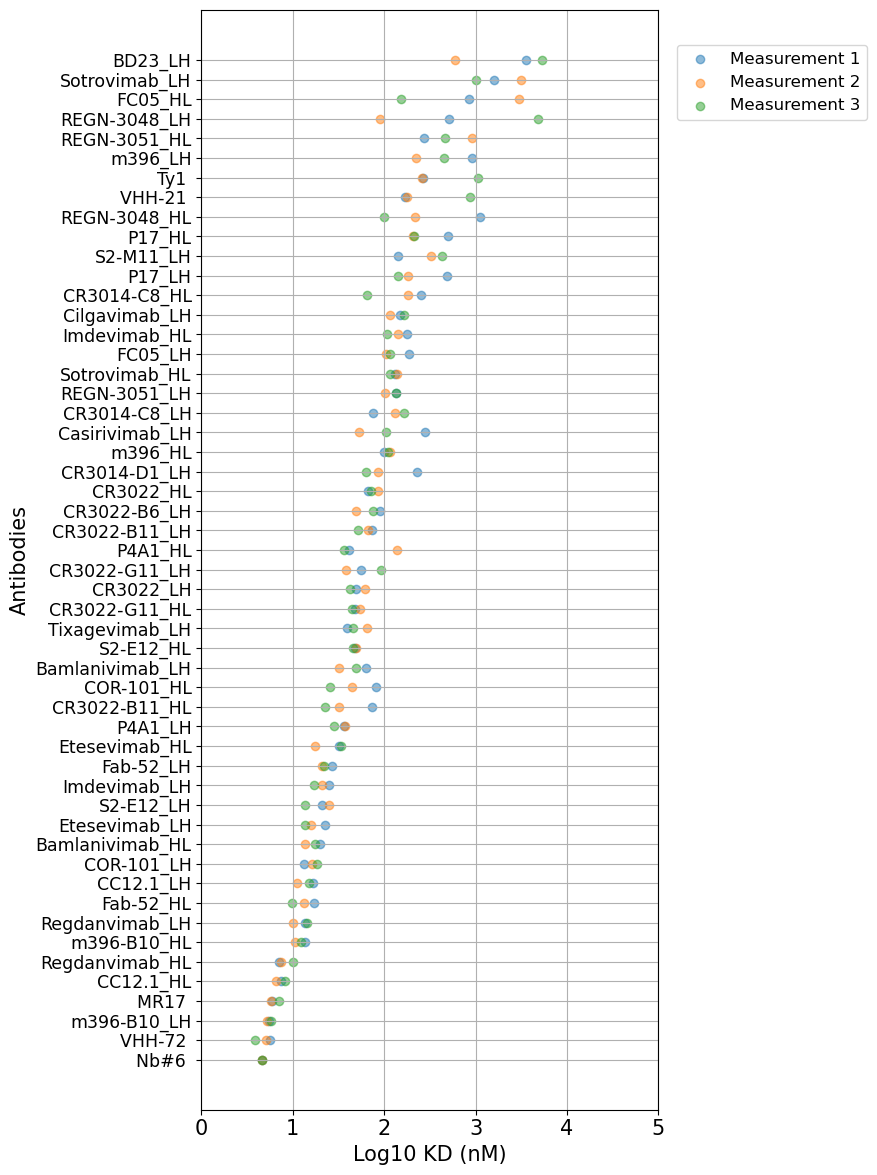

In [12]:
#How do binders bind to WT RBD for all three replicates

plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({'font.size': 15})

plt.figure(figsize=(7,12))
plt.subplots_adjust(right=1) 

x=np.arange(len(dfwt1))
y=dfwt1[1]
plt.scatter(y,x,alpha=0.5)

x=np.arange(len(dfwt1))
y=dfwt1[2]
plt.scatter(y,x,alpha=0.5)

x=np.arange(len(dfwt1))
y=dfwt1[3]
plt.scatter(y,x,alpha=0.5)

labels=list(dfwt1['Name&Ori'])
plt.yticks(range(len(labels)), labels, size='small')

plt.ylabel('Antibodies')
plt.xlabel('Log10 KD (nM)')

plt.xlim(0,5)

plt.grid()
plt.tight_layout()

# # # # Added code

lgd = plt.legend(['Measurement 1', 'Measurement 2', 'Measurement 3'], fontsize='12', loc=[1.04,0.9])

# plt.gca().invert_yaxis()
#plt.savefig('./figures/Antibody_WT_Epitope.png',dpi=300)

plt.savefig('./figures/aalphabio_affinities_original.png', dpi=300,bbox_inches='tight')
plt.show()



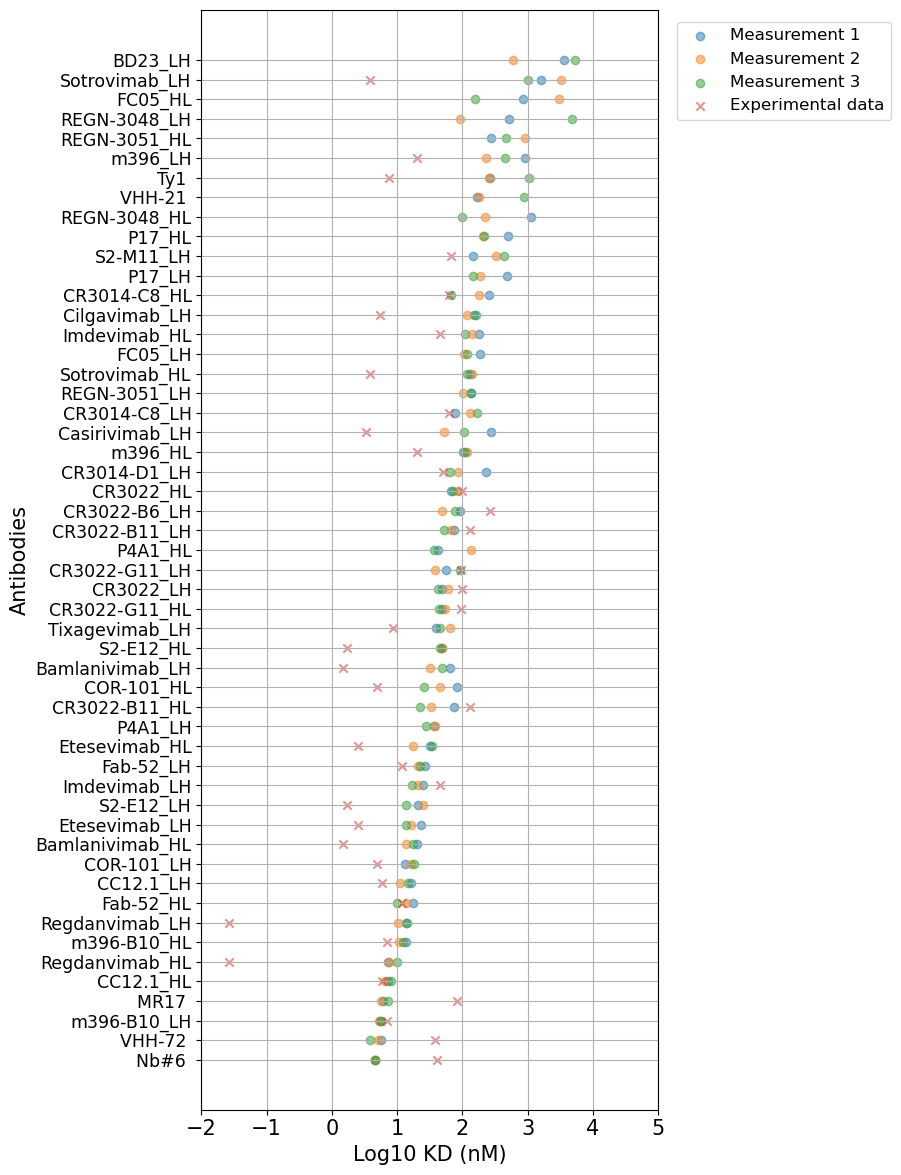

In [13]:
# # # # Added code

from scipy import stats
import random

#plot log10 KD values comparing measured vs experimental

plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({'font.size': 15})

plt.figure(figsize=(7,12))

x=np.arange(len(dfwt1_1))
y=dfwt1_1[1]
plt.scatter(y,x,alpha=0.5)

x=np.arange(len(dfwt1_1))
y=dfwt1_1[2]
plt.scatter(y,x,alpha=0.5)

x=np.arange(len(dfwt1_1))
y=dfwt1_1[3]
plt.scatter(y,x,alpha=0.5)

x=np.arange(len(dfwt1_1))
y=dfwt1_1['experimental_KD_nM_log10']
plt.scatter(y,x,alpha=0.5, marker ='x')

labels=list(dfwt1_1['Name&Ori'])
plt.yticks(range(len(labels)), labels, size='small')

plt.ylabel('Antibodies')
plt.xlabel('Log10 KD (nM)')

plt.xlim(-2,5)

plt.grid()
plt.tight_layout()

plt.legend(['Measurement 1', 'Measurement 2', 'Measurement 3', 'Experimental data'], fontsize='12', loc=[1.04,0.9])

#Calculate Spearman correlation between measured ranking and experimental ranking
dfwt1_1_rank1 = dfwt1_1.sort_values(by=[1])
rank_1 = dfwt1_1_rank1['rank'].values.tolist()
dfwt1_1_rank2 = dfwt1_1.sort_values(by=[2])
rank_2 = dfwt1_1_rank2['rank'].values.tolist()
dfwt1_1_rank3 = dfwt1_1.sort_values(by=[3])
rank_3 = dfwt1_1_rank3['rank'].values.tolist()
dfwt1_1_rankexp = dfwt1_1.sort_values(by=['experimental_KD_nM_log10'])
rank_exp = dfwt1_1_rankexp['rank'].values.tolist()
dfwt1_mean_rankexp = dfwt1_1.sort_values(by=['aff_mean'])
rank_mean = dfwt1_mean_rankexp['rank'].values.tolist()

#generate random ranking for comparison
rank_rand = list([*rank_1])
random.shuffle(rank_rand)

rho_1, pval_1 = stats.spearmanr(rank_2,rank_3)
rho_2, pval_2 = stats.spearmanr(rank_2,rank_exp)
rho_3, pval_3 = stats.spearmanr(rank_3,rank_exp)
rho_mean,pval_mean = stats.spearmanr(rank_mean,rank_exp) 
rho_rand, pval_rand = stats.spearmanr(rank_rand,rank_exp)

data= [['measurement 1',rho_1,pval_1],['measurement 2',rho_2,pval_2],['measurement 3',rho_3,pval_3], ['mean',rho_mean,pval_mean],['random',rho_rand,pval_rand]]

spearman = pd.DataFrame(data, columns=['name', 'spearman (rho)','p-value'])
spearman.to_csv('./output/spearman_correlation_pred_vs_exp_all.csv')


#Save image
plt.savefig('./figures/aalphabio_affinities_with_experimental_data.png', dpi=300, bbox_inches='tight')

plt.show()

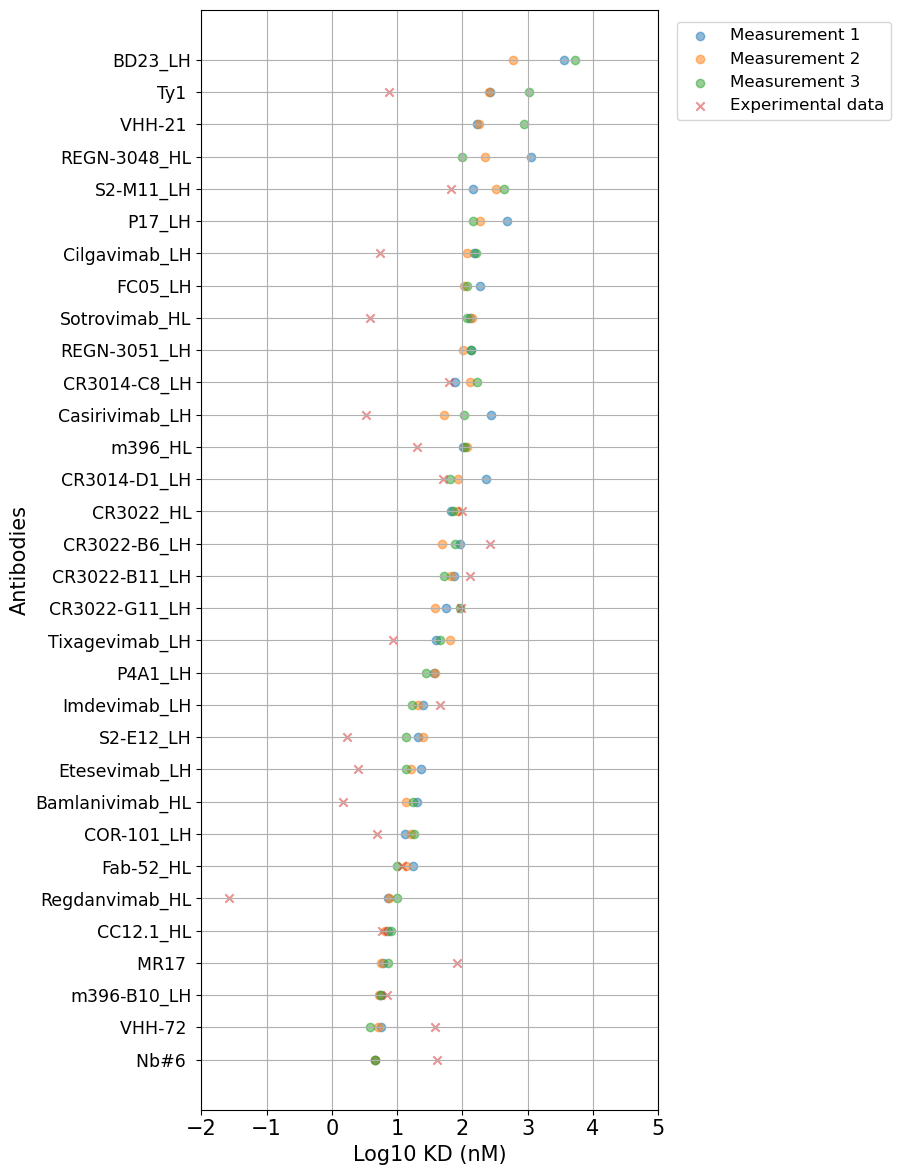

In [14]:
# # # # Added code

from scipy import stats
import random

#plot log10 KD values comparing measured vs experimental only for the best case scenario (closest direction)

plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({'font.size': 15})

plt.figure(figsize=(7,12))

x=np.arange(len(dfwt1_best))
y=dfwt1_best[1]
plt.scatter(y,x,alpha=0.5)

x=np.arange(len(dfwt1_best))
y=dfwt1_best[2]
plt.scatter(y,x,alpha=0.5)

x=np.arange(len(dfwt1_best))
y=dfwt1_best[3]
plt.scatter(y,x,alpha=0.5)

x=np.arange(len(dfwt1_best))
y=dfwt1_best['experimental_KD_nM_log10']
plt.scatter(y,x,alpha=0.5, marker ='x')

labels=list(dfwt1_best['Name&Ori'])
plt.yticks(range(len(labels)), labels, size='small')

plt.ylabel('Antibodies')
plt.xlabel('Log10 KD (nM)')

plt.xlim(-2,5)

plt.grid()
plt.tight_layout()

plt.legend(['Measurement 1', 'Measurement 2', 'Measurement 3', 'Experimental data'], fontsize='12', loc=[1.04,0.9])

#Save image
plt.savefig('./figures/aalphabio_affinities_with_experimental_data_closest_val.png', dpi=300, bbox_inches='tight')

plt.show()

#Calculate Spearman correlation between measured ranking and experimental ranking
dfwt1_best_rank1 = dfwt1_best.sort_values(by=[1])
rank_1 = dfwt1_best_rank1['rank'].values.tolist()
dfwt1_best_rank2 = dfwt1_best.sort_values(by=[2])
rank_2 = dfwt1_best_rank2['rank'].values.tolist()
dfwt1_best_rank3 = dfwt1_best.sort_values(by=[3])
rank_3 = dfwt1_best_rank3['rank'].values.tolist()
dfwt1_best_rank_mean = dfwt1_best.sort_values(by=['aff_mean'])
rank_mean = dfwt1_best_rank_mean['rank'].values.tolist()
dfwt1_best_rankexp = dfwt1_best.sort_values(by=['experimental_KD_nM_log10'])
rank_exp = dfwt1_best_rankexp['rank'].values.tolist()

#generate random ranking for comparison
rank_rand = list([*rank_1])
random.shuffle(rank_rand)

rho_1, pval_1 = stats.spearmanr(rank_2,rank_3)
rho_2, pval_2 = stats.spearmanr(rank_2,rank_exp)
rho_3, pval_3 = stats.spearmanr(rank_3,rank_exp)
rho_mean, pval_mean = stats.spearmanr(rank_mean,rank_exp)
rho_rand, pval_rand = stats.spearmanr(rank_rand,rank_exp)

data_best= [['measurement 1',rho_1,pval_1],['measurement 2',rho_2,pval_2],['measurement 3',rho_3,pval_3],['mean',rho_mean,pval_mean],['random',rho_rand,pval_rand]]

spearman = pd.DataFrame(data_best, columns=['name', 'spearman (rho)','p-value'])
spearman.to_csv('./output/spearman_correlation_pred_vs_exp_closest_val.csv')


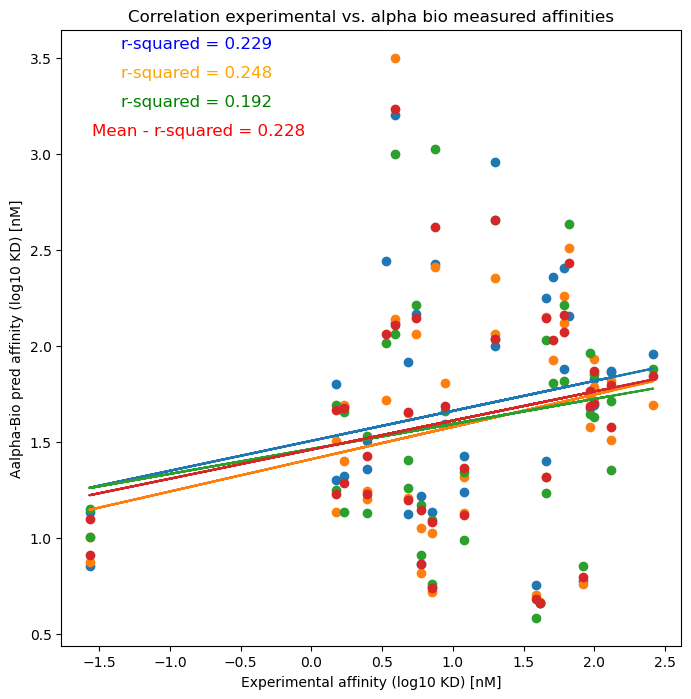

In [15]:
# # # # Added code

# Correlation between experimental values and alpha-bio predicted values
import numpy as np
from numpy.polynomial.polynomial import polyfit
import matplotlib.pyplot as plt

dfwt1_2 = dfwt1_1.dropna(subset=['experimental_KD_nM_log10'])

plt.rcParams.update(plt.rcParamsDefault)
plt.figure(figsize=(8,8))

plt.scatter(dfwt1_2['experimental_KD_nM_log10'], dfwt1_2[1])
b, m = polyfit(dfwt1_2['experimental_KD_nM_log10'], dfwt1_2[1], 1)
plt.plot(dfwt1_2['experimental_KD_nM_log10'], b + m * dfwt1_2['experimental_KD_nM_log10'], '-')
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(dfwt1_2['experimental_KD_nM_log10'],dfwt1_2[1])

plt.annotate("r-squared = {:.3f}".format(r_value), (-1.35, 3.55), c='blue', fontsize=12)

plt.scatter(dfwt1_2['experimental_KD_nM_log10'], dfwt1_2[2])
b, m = polyfit(dfwt1_2['experimental_KD_nM_log10'], dfwt1_2[2], 1)
plt.plot(dfwt1_2['experimental_KD_nM_log10'], b + m * dfwt1_2['experimental_KD_nM_log10'], '-')
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(dfwt1_2['experimental_KD_nM_log10'],dfwt1_2[2])

plt.annotate("r-squared = {:.3f}".format(r_value), (-1.35, 3.4), c='orange', fontsize=12)

plt.scatter(dfwt1_2['experimental_KD_nM_log10'], dfwt1_2[3])
b, m = polyfit(dfwt1_2['experimental_KD_nM_log10'], dfwt1_2[3], 1)
plt.plot(dfwt1_2['experimental_KD_nM_log10'], b + m * dfwt1_2['experimental_KD_nM_log10'], '-')
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(dfwt1_2['experimental_KD_nM_log10'],dfwt1_2[3])

plt.annotate("r-squared = {:.3f}".format(r_value), (-1.35, 3.25), c= 'green', fontsize=12)

plt.scatter(dfwt1_2['experimental_KD_nM_log10'], dfwt1_2["aff_mean"])
b, m = polyfit(dfwt1_2['experimental_KD_nM_log10'], dfwt1_2['aff_mean'], 1)
plt.plot(dfwt1_2['experimental_KD_nM_log10'], b + m * dfwt1_2['experimental_KD_nM_log10'], '-')
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(dfwt1_2['experimental_KD_nM_log10'],dfwt1_2['aff_mean'])

plt.annotate("Mean - r-squared = {:.3f}".format(r_value), (-1.55, 3.10), c= 'red', fontsize=12)

plt.xlabel('Experimental affinity (log10 KD) [nM]')
plt.ylabel('Aalpha-Bio pred affinity (log10 KD) [nM]')

plt.title('Correlation experimental vs. alpha bio measured affinities')

plt.savefig('./figures/aalphabio_correlation_log10.png', dpi=300, bbox_inches='tight')
plt.show()

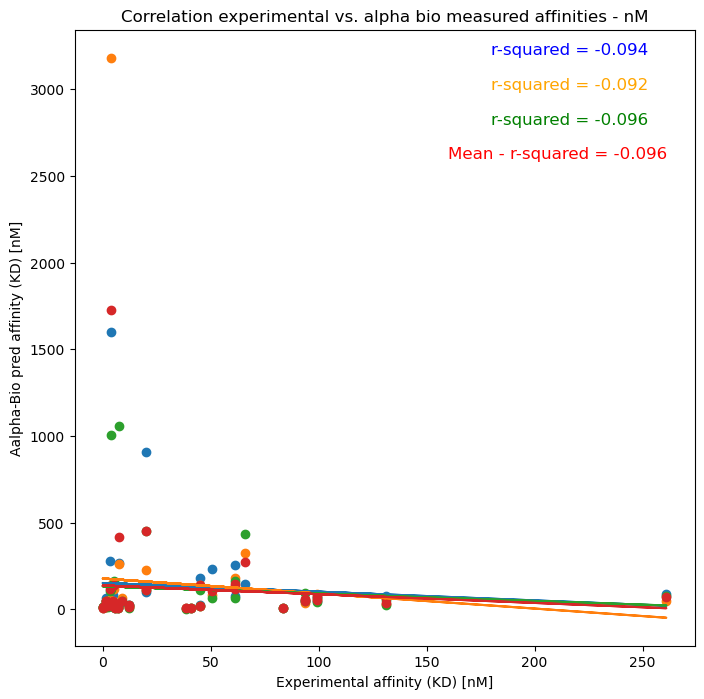

In [16]:
# # # # Added code

# Correlation between experimental values and alpha-bio predicted values without Log 10
import numpy as np
from numpy.polynomial.polynomial import polyfit
import matplotlib.pyplot as plt

dfwt1_2 = dfwt1_1.dropna(subset=['experimental_KD_nM'])

plt.rcParams.update(plt.rcParamsDefault)
plt.figure(figsize=(8,8))


dfwt1_2_1 = (10 ** dfwt1_2[1])

plt.scatter(dfwt1_2['experimental_KD_nM'], (dfwt1_2_1))
b, m = polyfit(dfwt1_2['experimental_KD_nM'], dfwt1_2_1, 1)
plt.plot(dfwt1_2['experimental_KD_nM'], b + m * dfwt1_2['experimental_KD_nM'], '-')
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(dfwt1_2['experimental_KD_nM'],dfwt1_2_1)

plt.annotate("r-squared = {:.3f}".format(r_value), (180,3200), c='blue', fontsize=12)

dfwt1_2_2 = (10 ** dfwt1_2[2])

plt.scatter(dfwt1_2['experimental_KD_nM'], dfwt1_2_2)
b, m = polyfit(dfwt1_2['experimental_KD_nM'], dfwt1_2_2, 1)
plt.plot(dfwt1_2['experimental_KD_nM'], b + m * dfwt1_2['experimental_KD_nM'], '-')
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(dfwt1_2['experimental_KD_nM'],dfwt1_2_2)

plt.annotate("r-squared = {:.3f}".format(r_value), (180, 3000), c='orange', fontsize=12)

dfwt1_2_3 = (10 ** dfwt1_2[3])

plt.scatter(dfwt1_2['experimental_KD_nM'], dfwt1_2_3)
b, m = polyfit(dfwt1_2['experimental_KD_nM'], dfwt1_2_3, 1)
plt.plot(dfwt1_2['experimental_KD_nM'], b + m * dfwt1_2['experimental_KD_nM'], '-')
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(dfwt1_2['experimental_KD_nM'],dfwt1_2_3)

plt.annotate("r-squared = {:.3f}".format(r_value), (180, 2800), c= 'green', fontsize=12)

dfwt1_2_mean = (10 ** dfwt1_2['aff_mean'])

plt.scatter(dfwt1_2['experimental_KD_nM'], dfwt1_2_mean)
b, m = polyfit(dfwt1_2['experimental_KD_nM'], dfwt1_2_mean, 1)
plt.plot(dfwt1_2['experimental_KD_nM'], b + m * dfwt1_2['experimental_KD_nM'], '-')
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(dfwt1_2['experimental_KD_nM'],dfwt1_2_mean)

plt.annotate("Mean - r-squared = {:.3f}".format(r_value), (160, 2600), c= 'red', fontsize=12)

plt.xlabel('Experimental affinity (KD) [nM]')
plt.ylabel('Aalpha-Bio pred affinity (KD) [nM]')

# To show it in log scale
# plt.yscale('log')
# plt.xscale('log')

plt.title('Correlation experimental vs. alpha bio measured affinities - nM')

plt.savefig('./figures/aalphabio_correlation_linear.png', dpi=300, bbox_inches='tight')
plt.show()

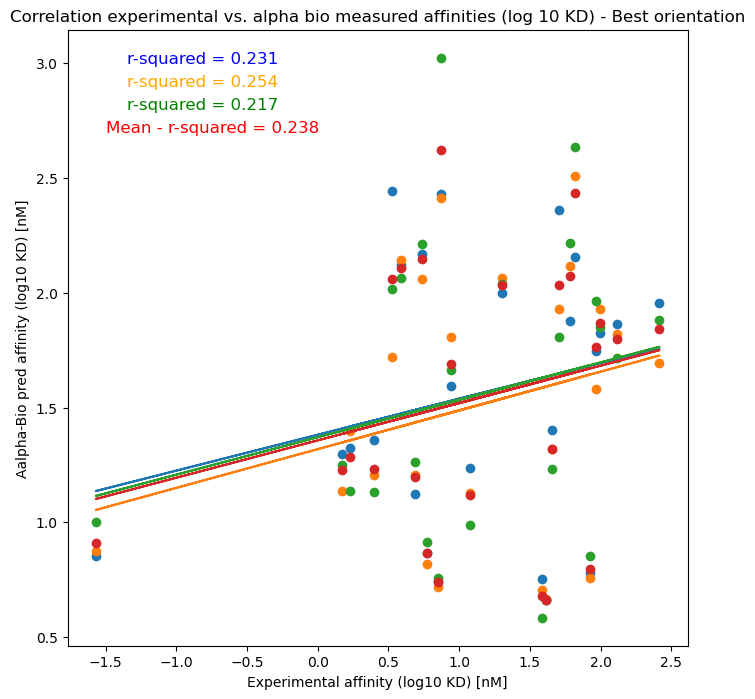

In [17]:
# # # # Added code

# Correlation between experimental values and alpha-bio predicted values - Best orientation
import numpy as np
from numpy.polynomial.polynomial import polyfit
import matplotlib.pyplot as plt

dfwt1_2_best = dfwt1_best.dropna(subset=['experimental_KD_nM_log10'])

plt.rcParams.update(plt.rcParamsDefault)
plt.figure(figsize=(8,8))

plt.scatter(dfwt1_2_best['experimental_KD_nM_log10'], dfwt1_2_best[1])
b, m = polyfit(dfwt1_2_best['experimental_KD_nM_log10'], dfwt1_2_best[1], 1)
plt.plot(dfwt1_2_best['experimental_KD_nM_log10'], b + m * dfwt1_2_best['experimental_KD_nM_log10'], '-')
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(dfwt1_2_best['experimental_KD_nM_log10'],dfwt1_2_best[1])

plt.annotate("r-squared = {:.3f}".format(r_value), (-1.35, 3), c='blue', fontsize=12)

plt.scatter(dfwt1_2_best['experimental_KD_nM_log10'], dfwt1_2_best[2])
b, m = polyfit(dfwt1_2_best['experimental_KD_nM_log10'], dfwt1_2_best[2], 1)
plt.plot(dfwt1_2_best['experimental_KD_nM_log10'], b + m * dfwt1_2_best['experimental_KD_nM_log10'], '-')
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(dfwt1_2_best['experimental_KD_nM_log10'],dfwt1_2_best[2])

plt.annotate("r-squared = {:.3f}".format(r_value), (-1.35, 2.9), c='orange', fontsize=12)

plt.scatter(dfwt1_2_best['experimental_KD_nM_log10'], dfwt1_2_best[3])
b, m = polyfit(dfwt1_2_best['experimental_KD_nM_log10'], dfwt1_2_best[3], 1)
plt.plot(dfwt1_2_best['experimental_KD_nM_log10'], b + m * dfwt1_2_best['experimental_KD_nM_log10'], '-')
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(dfwt1_2_best['experimental_KD_nM_log10'],dfwt1_2_best[3])

plt.annotate("r-squared = {:.3f}".format(r_value), (-1.35, 2.8), c= 'green', fontsize=12)

plt.scatter(dfwt1_2_best['experimental_KD_nM_log10'], dfwt1_2_best['aff_mean'])
b, m = polyfit(dfwt1_2_best['experimental_KD_nM_log10'], dfwt1_2_best['aff_mean'], 1)
plt.plot(dfwt1_2_best['experimental_KD_nM_log10'], b + m * dfwt1_2_best['experimental_KD_nM_log10'], '-')
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(dfwt1_2_best['experimental_KD_nM_log10'],dfwt1_2_best['aff_mean'])

plt.annotate("Mean - r-squared = {:.3f}".format(r_value), (-1.5, 2.7), c= 'red', fontsize=12)

plt.xlabel('Experimental affinity (log10 KD) [nM]')
plt.ylabel('Aalpha-Bio pred affinity (log10 KD) [nM]')

plt.title('Correlation experimental vs. alpha bio measured affinities (log 10 KD) - Best orientation')

plt.savefig('./figures/aalphabio_correlation_log10_closest_val.png', dpi=300, bbox_inches='tight')
plt.show()

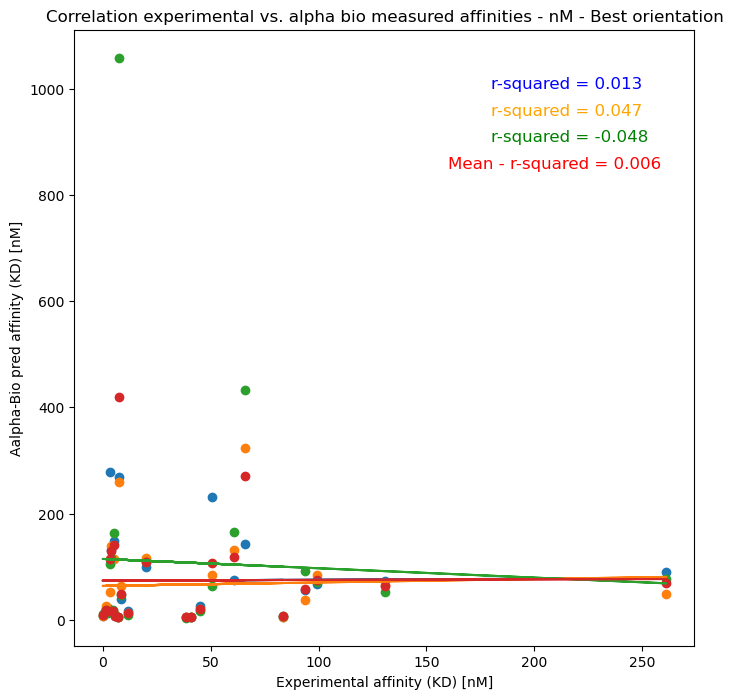

In [18]:
# # # # Added code

# Correlation between experimental values and alpha-bio predicted values without Log 10 - best orientation
import numpy as np
from numpy.polynomial.polynomial import polyfit
import matplotlib.pyplot as plt

plt.rcParams.update(plt.rcParamsDefault)
plt.figure(figsize=(8,8))

dfwt1_2_1_best = (10 ** dfwt1_2_best[1])

plt.scatter(dfwt1_2_best['experimental_KD_nM'], (dfwt1_2_1_best))
b, m = polyfit(dfwt1_2_best['experimental_KD_nM'], dfwt1_2_1_best, 1)
plt.plot(dfwt1_2_best['experimental_KD_nM'], b + m * dfwt1_2_best['experimental_KD_nM'], '-')
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(dfwt1_2_best['experimental_KD_nM'],dfwt1_2_1_best)

plt.annotate("r-squared = {:.3f}".format(r_value), (180,1000), c='blue', fontsize=12)

dfwt1_2_2_best = (10 ** dfwt1_2_best[2])

plt.scatter(dfwt1_2_best['experimental_KD_nM'], dfwt1_2_2_best)
b, m = polyfit(dfwt1_2_best['experimental_KD_nM'], dfwt1_2_2_best, 1)
plt.plot(dfwt1_2_best['experimental_KD_nM'], b + m * dfwt1_2_best['experimental_KD_nM'], '-')
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(dfwt1_2_best['experimental_KD_nM'],dfwt1_2_2_best)

plt.annotate("r-squared = {:.3f}".format(r_value), (180, 950), c='orange', fontsize=12)

dfwt1_2_3_best = (10 ** dfwt1_2_best[3])

plt.scatter(dfwt1_2_best['experimental_KD_nM'], dfwt1_2_3_best)
b, m = polyfit(dfwt1_2_best['experimental_KD_nM'], dfwt1_2_3_best, 1)
plt.plot(dfwt1_2_best['experimental_KD_nM'], b + m * dfwt1_2_best['experimental_KD_nM'], '-')
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(dfwt1_2_best['experimental_KD_nM'],dfwt1_2_3_best)

plt.annotate("r-squared = {:.3f}".format(r_value), (180, 900), c= 'green', fontsize=12)

dfwt1_2_mean_best = (10 ** dfwt1_2_best['aff_mean'])

plt.scatter(dfwt1_2_best['experimental_KD_nM'], dfwt1_2_mean_best)
b, m = polyfit(dfwt1_2_best['experimental_KD_nM'], dfwt1_2_mean_best, 1)
plt.plot(dfwt1_2_best['experimental_KD_nM'], b + m * dfwt1_2_best['experimental_KD_nM'], '-')
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(dfwt1_2_best['experimental_KD_nM'],dfwt1_2_mean_best)

plt.annotate("Mean - r-squared = {:.3f}".format(r_value), (160, 850), c= 'red', fontsize=12)


plt.xlabel('Experimental affinity (KD) [nM]')
plt.ylabel('Aalpha-Bio pred affinity (KD) [nM]')

# To show it in log scale
# plt.yscale('log')
# plt.xscale('log')

plt.title('Correlation experimental vs. alpha bio measured affinities - nM - Best orientation')

plt.savefig('./figures/aalphabio_correlation_linear_closest_val.png', dpi=300, bbox_inches='tight')
plt.show()

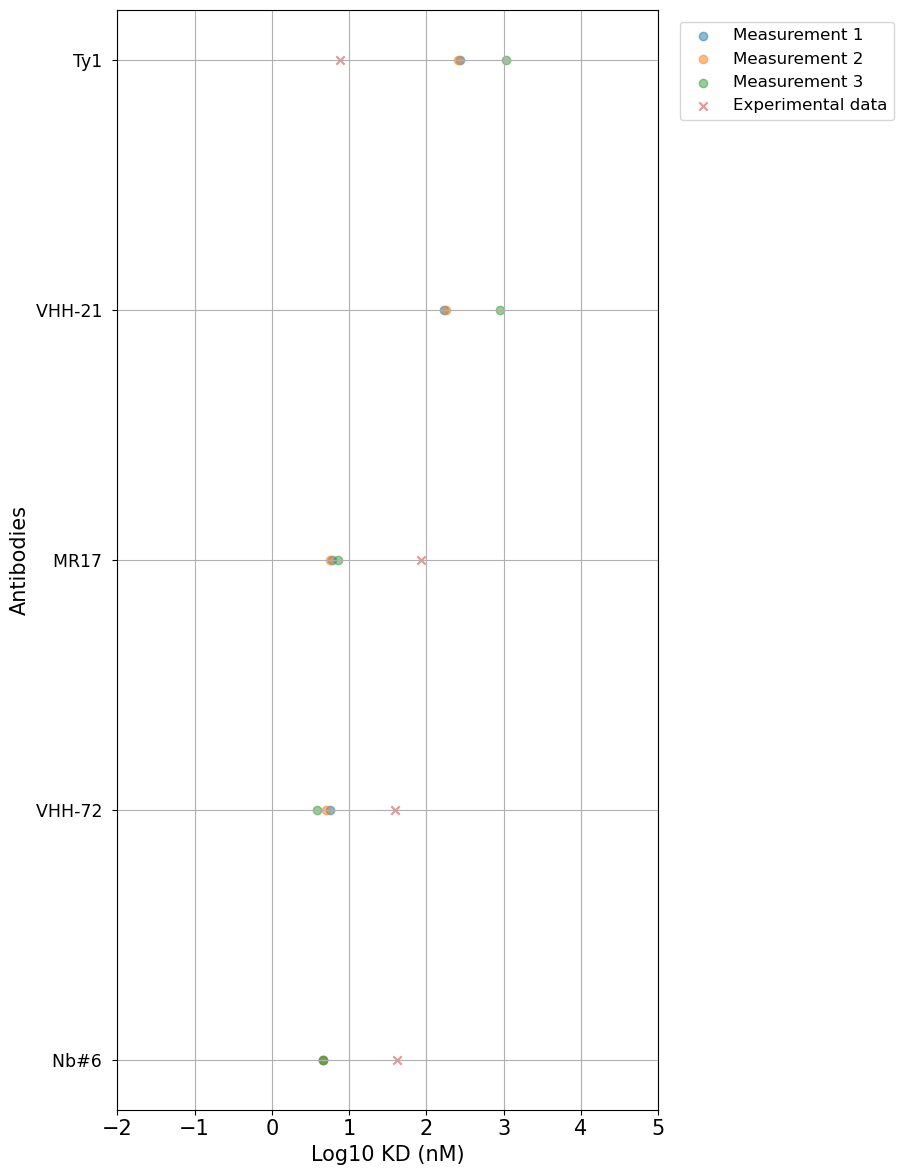

In [19]:
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({'font.size': 15})


dfwt1_3 = dfwt1_1[dfwt1_1['format']=='VHH']

plt.figure(figsize=(7,12))

x=np.arange(len(dfwt1_3))
y=dfwt1_3[1]
plt.scatter(y,x,alpha=0.5)

x=np.arange(len(dfwt1_3))
y=dfwt1_3[2]
plt.scatter(y,x,alpha=0.5)

x=np.arange(len(dfwt1_3))
y=dfwt1_3[3]
plt.scatter(y,x,alpha=0.5)

x=np.arange(len(dfwt1_3))
y=dfwt1_3['experimental_KD_nM_log10']
plt.scatter(y,x,alpha=0.5, marker ='x')

labels=list(dfwt1_3['Name&Ori'])
plt.yticks(range(len(labels)), labels, size='small')

plt.ylabel('Antibodies')
plt.xlabel('Log10 KD (nM)')

plt.xlim(-2,5)

plt.grid()
plt.tight_layout()

plt.legend(['Measurement 1', 'Measurement 2', 'Measurement 3', 'Experimental data'], fontsize='12', loc=[1.04,0.9])


#Calculate Spearman correlation between measured ranking and experimental ranking
dfwt1_3_rank1 = dfwt1_3.sort_values(by=[1])
rank_1 = dfwt1_3_rank1['rank'].values.tolist()
dfwt1_3_rank2 = dfwt1_3.sort_values(by=[2])
rank_2 = dfwt1_3_rank2['rank'].values.tolist()
dfwt1_3_rank3 = dfwt1_3.sort_values(by=[3])
rank_3 = dfwt1_3_rank3['rank'].values.tolist()
dfwt1_3_rank_mean = dfwt1_3.sort_values(by=['aff_mean'])
rank_mean = dfwt1_3_rank_mean['rank'].values.tolist()
dfwt1_3_rankexp = dfwt1_3.sort_values(by=['experimental_KD_nM_log10'])
rank_exp = dfwt1_3_rankexp['rank'].values.tolist()

#generate random ranking for comparison
rank_rand = list([*rank_1])
random.shuffle(rank_rand)

rho_1, pval_1 = stats.spearmanr(rank_2,rank_3)
rho_2, pval_2 = stats.spearmanr(rank_2,rank_exp)
rho_3, pval_3 = stats.spearmanr(rank_3,rank_exp)
rho_mean, pval_mean = stats.spearmanr(rank_mean,rank_exp)
rho_rand, pval_rand = stats.spearmanr(rank_rand,rank_exp)

data_VHH= [['measurement 1',rho_1,pval_1],['measurement 2',rho_2,pval_2],['measurement 3',rho_3,pval_3],['mean',rho_mean,pval_mean],['random',rho_rand,pval_rand]]

spearman = pd.DataFrame(data_VHH, columns=['name', 'spearman (rho)','p-value'])
spearman.to_csv('./output/spearman_correlation_pred_vs_exp_VHH.csv')

plt.savefig('./figures/aalphabio_affinities_with_experimental_data_VHH.png', dpi=300, bbox_inches='tight')
plt.show()

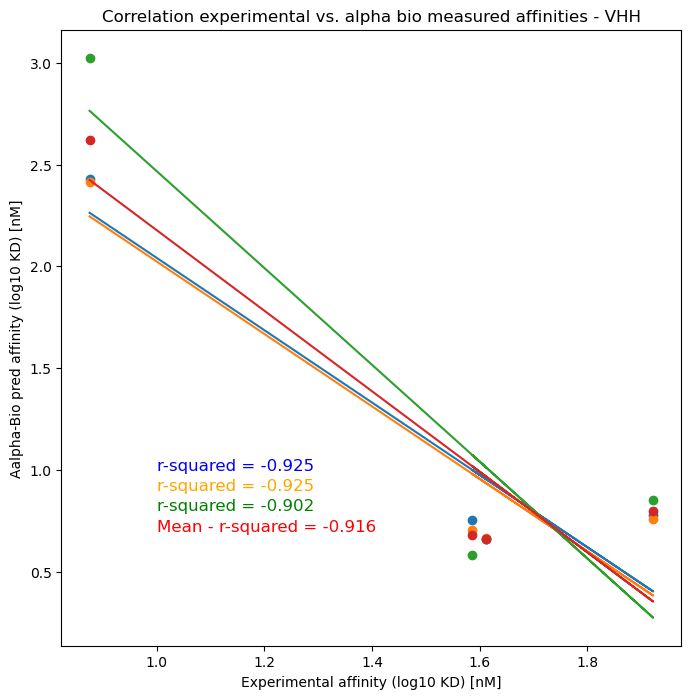

In [20]:
# # Added Code

#calculate correlation for VHH format

dfwt1_4 = dfwt1_3.dropna(subset=['experimental_KD_nM_log10'])

plt.rcParams.update(plt.rcParamsDefault)
plt.figure(figsize=(8,8))

plt.scatter(dfwt1_4['experimental_KD_nM_log10'], dfwt1_4[1])
b, m = polyfit(dfwt1_4['experimental_KD_nM_log10'], dfwt1_4[1], 1)
plt.plot(dfwt1_4['experimental_KD_nM_log10'], b + m * dfwt1_4['experimental_KD_nM_log10'], '-')
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(dfwt1_4['experimental_KD_nM_log10'],dfwt1_4[1])

plt.annotate("r-squared = {:.3f}".format(r_value), (1, 1), c='blue', fontsize=12)

plt.scatter(dfwt1_4['experimental_KD_nM_log10'], dfwt1_4[2])
b, m = polyfit(dfwt1_4['experimental_KD_nM_log10'], dfwt1_4[2], 1)
plt.plot(dfwt1_4['experimental_KD_nM_log10'], b + m * dfwt1_4['experimental_KD_nM_log10'], '-')
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(dfwt1_4['experimental_KD_nM_log10'],dfwt1_4[2])

plt.annotate("r-squared = {:.3f}".format(r_value), (1, 0.9), c='orange', fontsize=12)

plt.scatter(dfwt1_4['experimental_KD_nM_log10'], dfwt1_4[3])
b, m = polyfit(dfwt1_4['experimental_KD_nM_log10'], dfwt1_4[3], 1)
plt.plot(dfwt1_4['experimental_KD_nM_log10'], b + m * dfwt1_4['experimental_KD_nM_log10'], '-')
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(dfwt1_4['experimental_KD_nM_log10'],dfwt1_4[3])

plt.annotate("r-squared = {:.3f}".format(r_value), (1, 0.8), c= 'green', fontsize=12)

plt.scatter(dfwt1_4['experimental_KD_nM_log10'], dfwt1_4['aff_mean'])
b, m = polyfit(dfwt1_4['experimental_KD_nM_log10'], dfwt1_4['aff_mean'], 1)
plt.plot(dfwt1_4['experimental_KD_nM_log10'], b + m * dfwt1_4['experimental_KD_nM_log10'], '-')
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(dfwt1_4['experimental_KD_nM_log10'],dfwt1_4['aff_mean'])

plt.annotate("Mean - r-squared = {:.3f}".format(r_value), (1, 0.7), c= 'red', fontsize=12)


plt.xlabel('Experimental affinity (log10 KD) [nM]')
plt.ylabel('Aalpha-Bio pred affinity (log10 KD) [nM]')

plt.title('Correlation experimental vs. alpha bio measured affinities - VHH')

plt.savefig('./figures/aalphabio_correlation_VHH_log10.png', dpi=300, bbox_inches='tight')
plt.show()

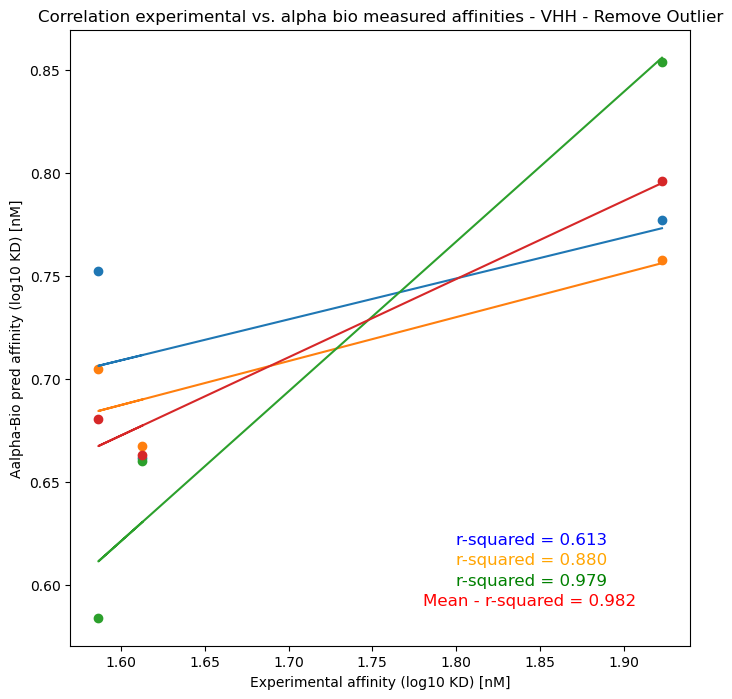

In [21]:
# # Added Code

#calculate correlation for VHH format - Drop outlier

dfwt1_4 = dfwt1_3.dropna(subset=['experimental_KD_nM_log10'])

dfwt1_4  = dfwt1_4.drop([45])

plt.rcParams.update(plt.rcParamsDefault)
plt.figure(figsize=(8,8))

plt.scatter(dfwt1_4['experimental_KD_nM_log10'], dfwt1_4[1])
b, m = polyfit(dfwt1_4['experimental_KD_nM_log10'], dfwt1_4[1], 1)
plt.plot(dfwt1_4['experimental_KD_nM_log10'], b + m * dfwt1_4['experimental_KD_nM_log10'], '-')
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(dfwt1_4['experimental_KD_nM_log10'],dfwt1_4[1])

plt.annotate("r-squared = {:.3f}".format(r_value), (1.8, 0.62), c='blue', fontsize=12)

plt.scatter(dfwt1_4['experimental_KD_nM_log10'], dfwt1_4[2])
b, m = polyfit(dfwt1_4['experimental_KD_nM_log10'], dfwt1_4[2], 1)
plt.plot(dfwt1_4['experimental_KD_nM_log10'], b + m * dfwt1_4['experimental_KD_nM_log10'], '-')
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(dfwt1_4['experimental_KD_nM_log10'],dfwt1_4[2])

plt.annotate("r-squared = {:.3f}".format(r_value), (1.8, 0.61), c='orange', fontsize=12)

plt.scatter(dfwt1_4['experimental_KD_nM_log10'], dfwt1_4[3])
b, m = polyfit(dfwt1_4['experimental_KD_nM_log10'], dfwt1_4[3], 1)
plt.plot(dfwt1_4['experimental_KD_nM_log10'], b + m * dfwt1_4['experimental_KD_nM_log10'], '-')
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(dfwt1_4['experimental_KD_nM_log10'],dfwt1_4[3])

plt.annotate("r-squared = {:.3f}".format(r_value), (1.8, 0.6), c= 'green', fontsize=12)

plt.scatter(dfwt1_4['experimental_KD_nM_log10'], dfwt1_4['aff_mean'])
b, m = polyfit(dfwt1_4['experimental_KD_nM_log10'], dfwt1_4['aff_mean'], 1)
plt.plot(dfwt1_4['experimental_KD_nM_log10'], b + m * dfwt1_4['experimental_KD_nM_log10'], '-')
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(dfwt1_4['experimental_KD_nM_log10'],dfwt1_4['aff_mean'])

plt.annotate("Mean - r-squared = {:.3f}".format(r_value), (1.78, 0.59), c= 'red', fontsize=12)

plt.xlabel('Experimental affinity (log10 KD) [nM]')
plt.ylabel('Aalpha-Bio pred affinity (log10 KD) [nM]')

plt.title('Correlation experimental vs. alpha bio measured affinities - VHH - Remove Outlier')

plt.savefig('./figures/aalphabio_correlation_VHH_log10_drop_outlier.png', dpi=300, bbox_inches='tight')
plt.show()

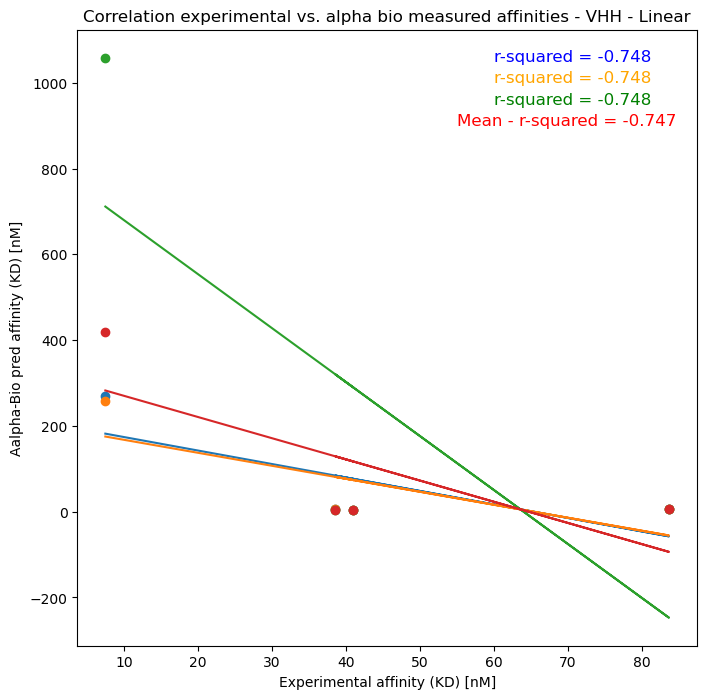

In [22]:
# # Added Code

#calculate correlation for VHH format (original scale) - no log 10

dfwt1_4 = dfwt1_3.dropna(subset=['experimental_KD_nM'])


plt.rcParams.update(plt.rcParamsDefault)
plt.figure(figsize=(8,8))

dfwt1_4_1 = (10 ** dfwt1_4[1])

plt.scatter(dfwt1_4['experimental_KD_nM'], dfwt1_4_1)
b, m = polyfit(dfwt1_4['experimental_KD_nM'], dfwt1_4_1, 1)
plt.plot(dfwt1_4['experimental_KD_nM'], b + m * dfwt1_4['experimental_KD_nM'], '-')
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(dfwt1_4['experimental_KD_nM'],dfwt1_4_1)

plt.annotate("r-squared = {:.3f}".format(r_value), (60, 1050), c='blue', fontsize=12)

dfwt1_4_2 = (10 ** dfwt1_4[2])

plt.scatter(dfwt1_4['experimental_KD_nM'], dfwt1_4_2)
b, m = polyfit(dfwt1_4['experimental_KD_nM'], dfwt1_4_2, 1)
plt.plot(dfwt1_4['experimental_KD_nM'], b + m * dfwt1_4['experimental_KD_nM'], '-')
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(dfwt1_4['experimental_KD_nM'],dfwt1_4_2)

plt.annotate("r-squared = {:.3f}".format(r_value), (60, 1000), c='orange', fontsize=12)

dfwt1_4_3 = (10 ** dfwt1_4[3])

plt.scatter(dfwt1_4['experimental_KD_nM'], dfwt1_4_3)
b, m = polyfit(dfwt1_4['experimental_KD_nM'], dfwt1_4_3, 1)
plt.plot(dfwt1_4['experimental_KD_nM'], b + m * dfwt1_4['experimental_KD_nM'], '-')
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(dfwt1_4['experimental_KD_nM'],dfwt1_4_3)

plt.annotate("r-squared = {:.3f}".format(r_value), (60, 950), c= 'green', fontsize=12)

dfwt1_4_mean = (10 ** dfwt1_4['aff_mean'])

plt.scatter(dfwt1_4['experimental_KD_nM'], dfwt1_4_mean)
b, m = polyfit(dfwt1_4['experimental_KD_nM'], dfwt1_4_mean, 1)
plt.plot(dfwt1_4['experimental_KD_nM'], b + m * dfwt1_4['experimental_KD_nM'], '-')
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(dfwt1_4['experimental_KD_nM'],dfwt1_4_mean)

plt.annotate("Mean - r-squared = {:.3f}".format(r_value), (55, 900), c= 'red', fontsize=12)

plt.xlabel('Experimental affinity (KD) [nM]')
plt.ylabel('Aalpha-Bio pred affinity (KD) [nM]')

plt.title('Correlation experimental vs. alpha bio measured affinities - VHH - Linear')

plt.savefig('./figures/aalphabio_correlation_VHH_linear.png', dpi=300, bbox_inches='tight')
plt.show()

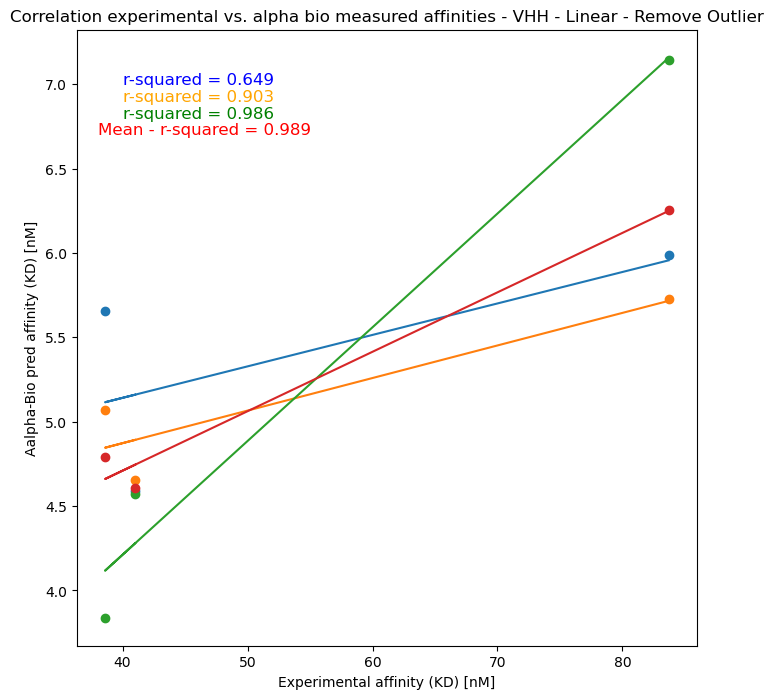

In [23]:
# # Added Code

#calculate correlation for VHH format (original scale) - no log 10 - Drop outlier Ty1

dfwt1_4 = dfwt1_3.dropna(subset=['experimental_KD_nM'])
dfwt1_4  = dfwt1_4.drop([45])

plt.rcParams.update(plt.rcParamsDefault)
plt.figure(figsize=(8,8))

dfwt1_4_1 = (10 ** dfwt1_4[1])

plt.scatter(dfwt1_4['experimental_KD_nM'], dfwt1_4_1)
b, m = polyfit(dfwt1_4['experimental_KD_nM'], dfwt1_4_1, 1)
plt.plot(dfwt1_4['experimental_KD_nM'], b + m * dfwt1_4['experimental_KD_nM'], '-')
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(dfwt1_4['experimental_KD_nM'],dfwt1_4_1)

plt.annotate("r-squared = {:.3f}".format(r_value), (40, 7), c='blue', fontsize=12)

dfwt1_4_2 = (10 ** dfwt1_4[2])

plt.scatter(dfwt1_4['experimental_KD_nM'], dfwt1_4_2)
b, m = polyfit(dfwt1_4['experimental_KD_nM'], dfwt1_4_2, 1)
plt.plot(dfwt1_4['experimental_KD_nM'], b + m * dfwt1_4['experimental_KD_nM'], '-')
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(dfwt1_4['experimental_KD_nM'],dfwt1_4_2)

plt.annotate("r-squared = {:.3f}".format(r_value), (40, 6.9), c='orange', fontsize=12)

dfwt1_4_3 = (10 ** dfwt1_4[3])

plt.scatter(dfwt1_4['experimental_KD_nM'], dfwt1_4_3)
b, m = polyfit(dfwt1_4['experimental_KD_nM'], dfwt1_4_3, 1)
plt.plot(dfwt1_4['experimental_KD_nM'], b + m * dfwt1_4['experimental_KD_nM'], '-')
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(dfwt1_4['experimental_KD_nM'],dfwt1_4_3)

plt.annotate("r-squared = {:.3f}".format(r_value), (40, 6.8), c= 'green', fontsize=12)

dfwt1_4_mean = (10 ** dfwt1_4['aff_mean'])

plt.scatter(dfwt1_4['experimental_KD_nM'], dfwt1_4_mean)
b, m = polyfit(dfwt1_4['experimental_KD_nM'], dfwt1_4_mean, 1)
plt.plot(dfwt1_4['experimental_KD_nM'], b + m * dfwt1_4['experimental_KD_nM'], '-')
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(dfwt1_4['experimental_KD_nM'],dfwt1_4_mean)

plt.annotate("Mean - r-squared = {:.3f}".format(r_value), (38, 6.7), c= 'red', fontsize=12)

plt.xlabel('Experimental affinity (KD) [nM]')
plt.ylabel('Aalpha-Bio pred affinity (KD) [nM]')

plt.title('Correlation experimental vs. alpha bio measured affinities - VHH - Linear - Remove Outlier')

plt.savefig('./figures/aalphabio_correlation_VHH_linear_drop_outlier.png', dpi=300, bbox_inches='tight')
plt.show()

# Epitope antibody pairwise comparison

In [24]:
# Which binders to use for epitope mapping?
# Selecting binders that bound at a KD of300nM (2.5 LOG 10 AFF) 
# or stronger affinity to WT RBD
goodwtbinders_df=dfwtpass[dfwtpass.aff_mean < 2.5].sort_values(by='mata_description')
comparisonbinders=list(goodwtbinders_df.mata_description.unique())
print('How many binders used for pairwise epitope extraction?')
print(len(comparisonbinders))

How many binders used for pairwise epitope extraction?
47


In [117]:
### ~20 minute runtime

#Determine unique list of residues (pos) to do comparison
listpos=df.sort_values(by='pos').dropna(subset=['pos']).pos.unique().astype(int)
resultslist=[]

for queryxx in range(0,len(comparisonbinders)):
    #selecting query binders
    dftemp1 = df[df.mata_description == comparisonbinders[queryxx]]
    print(queryxx)
    for compxx in range(0,len(comparisonbinders)):
        
        #selecting comparison binder
        dftemp2 = df[df.mata_description == comparisonbinders[compxx]]
        
        # normalizing by mean average across SSM
        dftemp1.aff_mean = dftemp1.aff_mean - np.mean(dftemp1.aff_mean)
        dftemp2.aff_mean = dftemp2.aff_mean - np.mean(dftemp2.aff_mean)
    
        #empty lists
        difflist=[]
        plist=[]
        poslist=[]
        querylist=[]
        comparisonlist=[]

        for posxx in range (0,len(listpos)):
            #comparing across position
            
            #all affinity means
            dftemp1_values=dftemp1[dftemp1.pos == listpos[posxx]].aff_mean
            dftemp2_values=dftemp2[dftemp2.pos == listpos[posxx]].aff_mean
            
            #mean difference across substitutions
            diff = np.mean(dftemp1_values) - np.mean(dftemp2_values)
            
            #p-value calculation across substitutions
            #if there are no affinity values in the query or comparison binder, set p to 1
            if ((len(dftemp1_values) > 0)&(len(dftemp2_values) > 0)):
                [stat,p] = stats.mstats.mannwhitneyu(dftemp1_values,dftemp2_values)
            else:
                [stat,p] = [0,1]
            
            #append results to lists
            poslist.append(listpos[posxx])
            difflist.append(diff)
            plist.append(p)
            querylist.append(dftemp1.mata_description.iloc[0])
            comparisonlist.append(dftemp2.mata_description.iloc[0])
        
        #creates output dataframe and appends to list of dataframes
        resultsdf=pd.DataFrame({'pos':poslist,'diff':difflist,'pvalue':plist,'query':querylist,'comp':comparisonlist})

        resultslist.append(resultsdf)
        
finaldf=pd.concat(resultslist).sort_values(by='pvalue')
finaldf.to_csv('./raw_data/Supplementary_Table7_EpitopeComparisonRaw.csv')

In [118]:
#loading results from previous iterations
finaldf = pd.read_csv('Supplementary_Table7_EpitopeComparisonRaw.csv')

#p-value bonferroni correction
correction=np.int(np.float64(len(comparisonbinders)) * np.float64(len(listpos))) 

#all results
# finaldf=pd.concat(resultslist).sort_values(by='pvalue')
# finaldf.to_csv('20210321_epitoperesults.csv')

#filtered mutants based on pvalue thresholding and those with loss of binding
finaldf_fil=finaldf[(finaldf.pvalue < (0.05/correction)) & (finaldf['diff']>0)].sort_values(by='query')
dftemp=df[['mata_description','Name']].drop_duplicates(subset=['mata_description'])
finaldf_fil=finaldf_fil.merge(dftemp,left_on='query',right_on='mata_description',how='left').sort_values('Name')




# Epitope Heatmap

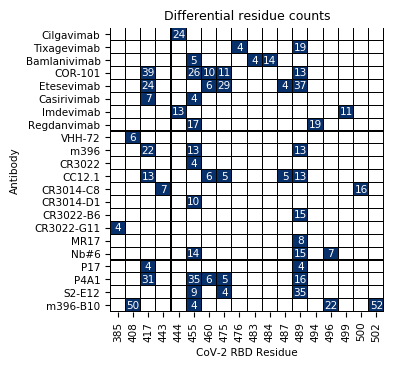

In [124]:
def heatmap1(finaldf_fil,var_name,count_cutoff,sorted_index,height,width,name):

    finaldf_fil['query_pos']=finaldf_fil[var_name] + '&' + finaldf_fil.pos.astype(str)
    dftemp1=pd.DataFrame(finaldf_fil.query_pos.value_counts())
    dftemp1=dftemp1[dftemp1.query_pos > count_cutoff]

    
    indextemp=pd.Series(dftemp1.index)
    dftemp1=dftemp1.reset_index(drop=False)

    dftemp1[[var_name,'pos']]=indextemp.str.split(pat="&",expand=True)
    dftemp1_h=dftemp1.pivot(columns='pos',index=var_name,values='query_pos')

    if len(sorted_index)>0:
        dftemp1_h=dftemp1_h.reindex(index = sorted_index)
    
    dftemp1_h=dftemp1_h.fillna(0)

    dftemp2_h= dftemp1_h[dftemp1_h > count_cutoff]
    
    dftemp2_h= dftemp2_h.dropna(axis=1,how='all')
    dftemp2_h= dftemp2_h.dropna(axis=0,how='all')
    
    plt.rcParams.update(plt.rcParamsDefault)
    plt.rcParams.update({'font.size': 7.5})
    plt.figure(figsize=(width,height))

    sns.heatmap(data=dftemp2_h, cmap='Blues',linewidth=.1,linecolor='black', 
                annot=True, vmax=1, vmin=0, cbar=False)
    
    plt.title('Differential residue counts')
    plt.xticks(rotation=90) 
    plt.xlabel('CoV-2 RBD Residue')
    plt.ylabel('Antibody')
    plt.tight_layout()
    plt.savefig(name,dpi=300)
    plt.show()
    return(dftemp2_h)

sorted_index1 = [
 'Cilgavimab',
 'Tixagevimab',
 'Bamlanivimab',
 'COR-101',
 'Etesevimab',
 'Casirivimab',
 'Imdevimab',
 'Regdanvimab',
 'VHH-72',
 'm396',
 'CR3022',
 'CC12.1',
 'CR3014-C8',
 'CR3014-D1',
 'CR3022-B11',
 'CR3022-B6',
 'CR3022-G11',
 'MR17',
 'Nb#6',
 'P17',
 'P4A1',
 'S2-E12',
 'm396-B10']


#Full heatmap with all dataset
finalcounts=heatmap1(finaldf_fil,'Name',3,sorted_index1,3.7,4,'./full_epitope_counts.png')
finalcounts.to_csv('Supplementary_Table8_EpitopeComparisonFinal.csv')

In [65]:
finaldf_fil

pos      diff        pvalue             query              comp  \
910   484  1.492792  6.150000e-06   CoV_binder_3_HL   CoV_binder_4_HL   
924   484  1.613696  5.050000e-06   CoV_binder_3_HL  CoV_binder_21_LH   
923   373  0.327143  4.500000e-07   CoV_binder_3_HL        SARS_VHH72   
921   484  1.574441  6.150000e-06   CoV_binder_3_HL     CoV_binder_29   
920   494  0.831787  4.630000e-06   CoV_binder_3_HL        SARS_VHH72   
919   483  1.074158  5.310000e-07   CoV_binder_3_HL        SARS_VHH72   
918   335  0.412503  1.540000e-06   CoV_binder_3_HL        SARS_VHH72   
917   484  1.591415  5.050000e-06   CoV_binder_3_HL   CoV_binder_2_LH   
916   484  1.616094  4.140000e-06   CoV_binder_3_HL  CoV_binder_13_LH   
925   455  0.369839  3.320000e-06   CoV_binder_3_HL   CoV_binder_2_LH   
915   320  0.503264  3.810000e-07   CoV_binder_3_HL        SARS_VHH72   
913   385  0.459065  4.840000e-06   CoV_binder_3_HL        SARS_VHH72   
912   484  1.816835  3.390000e-06   CoV_binder_3_HL        SARS_VHH72   
911   455  0.690241  7.050000e-07   CoV_binder_3_HL        SARS_VHH72   
909   443  0.546749  1.690000e-06   CoV_binder_3_HL        SARS_VHH72   
908   484  1.571374  6.150000e-06   CoV_binder_3_HL  CoV_binder_17_LH   
907   494  0.822082  6.420000e-06   CoV_binder_3_HL   CoV_binder_9_LH   
906   484  1.678754  6.150000e-06   CoV_binder_3_HL    CR3022_scFv_LH   
905   455  0.531602  7.050000e-07   CoV_binder_3_HL    CR3022_scFv_LH   
914   484  1.799985  4.140000e-06   CoV_binder_3_HL     CoV_binder_28   
926   332  0.378716  5.050000e-06   CoV_binder_3_HL        SARS_VHH72   
922   489  0.469731  1.400000e-06   CoV_binder_3_HL        SARS_VHH72   
928   484  1.588618  5.050000e-06   CoV_binder_3_HL   CoV_binder_9_LH   
904   373  0.256523  4.840000e-06   CoV_binder_3_HL    CR3022_scFv_LH   
945   483  0.830056  1.020000e-06   CoV_binder_3_LH    CR3022_scFv_LH   
944   484  1.093044  6.150000e-06   CoV_binder_3_LH     CoV_binder_28   
943   332  0.372442  5.050000e-06   CoV_binder_3_LH        SARS_VHH72   
942   373  0.305520  1.400000e-06   CoV_binder_3_LH        SARS_VHH72   
927   479  0.304235  1.920000e-06   CoV_binder_3_HL        SARS_VHH72   
940   324  0.546621  1.000000e-06   CoV_binder_3_LH        SARS_VHH72   
...   ...       ...           ...               ...               ...   
213   373  0.290235  5.310000e-07  CoV_binder_13_LH        SARS_VHH72   
215   502  1.384597  2.700000e-06  CoV_binder_13_LH   CoV_binder_4_HL   
214   408  1.185967  5.450000e-06  CoV_binder_13_LH   CoV_binder_6_LH   
171   502  1.378190  2.700000e-06  CoV_binder_13_LH  CoV_binder_18_LH   
170   502  1.307371  2.250000e-06  CoV_binder_13_LH  CoV_binder_22_LH   
169   408  1.302190  7.050000e-07  CoV_binder_13_LH     CoV_binder_31   
168   408  1.365295  1.690000e-06  CoV_binder_13_LH  CoV_binder_10_LH   
167   335  0.303669  1.540000e-06  CoV_binder_13_LH        SARS_VHH72   
172   502  1.238112  4.670000e-06  CoV_binder_13_LH  CoV_binder_24_LH   
165   502  1.356008  2.700000e-06  CoV_binder_13_LH   CoV_binder_8_HL   
164   502  1.472786  5.590000e-06  CoV_binder_13_HL  CoV_binder_20_LH   
163   502  1.658559  2.250000e-06  CoV_binder_13_HL  CoV_binder_16_LH   
162   443  1.250184  3.920000e-06  CoV_binder_13_HL        SARS_VHH72   
161   502  1.597808  1.860000e-06  CoV_binder_13_HL   CoV_binder_1_LH   
159   502  1.586615  2.250000e-06  CoV_binder_13_HL  CoV_binder_24_HL   
216   408  1.014568  5.450000e-06  CoV_binder_13_LH  CoV_binder_24_LH   
0     475  0.416094  5.620000e-06    CR3022_scFv_LH  CoV_binder_14_HL   
1     328  0.020715  4.670000e-06    CR3022_scFv_LH  CoV_binder_27_HL   
2     500  0.175832  2.370000e-06    CR3022_scFv_LH        SARS_VHH72   
3     476  0.022006  1.190000e-06    CR3022_scFv_LH  CoV_binder_27_HL   
4     483  0.156171  2.620000e-06    CR3022_scFv_LH        SARS_VHH72   
5     445  0.162039  2.370000e-06    CR3022_scFv_LH        SARS_VHH72   
1299  408  0.772758  2.000000e-06        SARS_VHH72  CoV_binder_

# Other plots

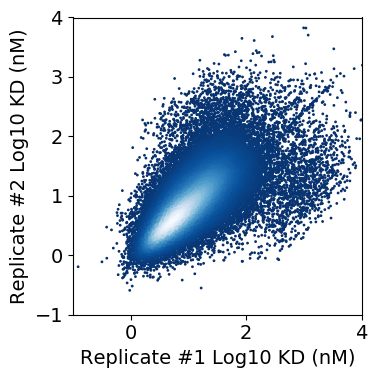

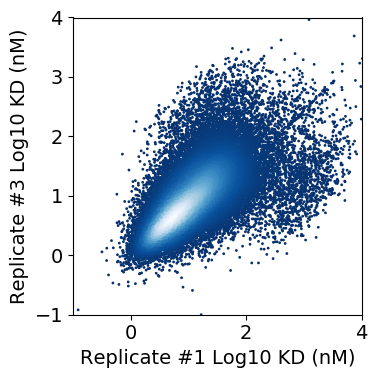

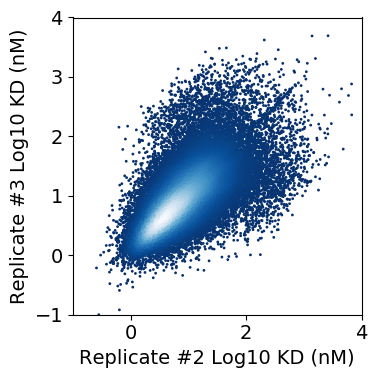

In [43]:
from scipy.stats import gaussian_kde

dftemp = df.dropna() #measurements with values in all three replicates

def plotscatter(rep1,rep2):
    x = dftemp[rep1]
    y = dftemp[rep2]

    xy = np.vstack([x,y])
    z = gaussian_kde(xy)(xy)

    plt.rcParams.update({'font.size': 14})

    plt.figure(figsize=(4,4))
    plt.scatter(x, y, c=z, s=1, cmap='Blues_r')
    plt.xlim(-1,4)
    plt.ylim(-1,4)
    plt.xlabel('Replicate #'+str(rep1)+' Log10 KD (nM)')
    plt.ylabel('Replicate #'+str(rep2)+' Log10 KD (nM)')
    plt.tight_layout()
    plt.savefig('./figures/epitope_replicate'+str(rep1)+str(rep2)+'.png',dpi=300)
    plt.show()
    
    
### Replicate plots
plotscatter(1,2)
plotscatter(1,3)
plotscatter(2,3)

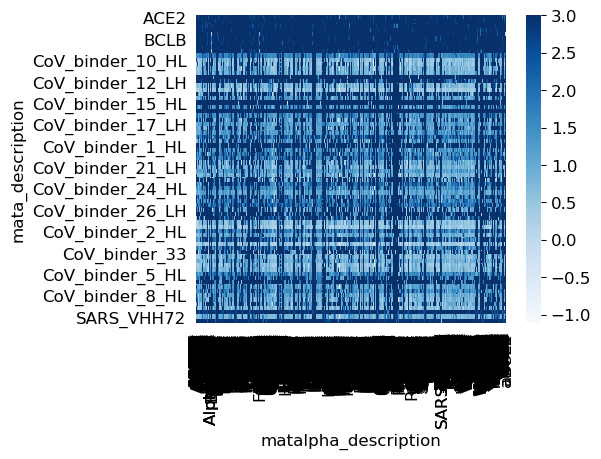

In [44]:
#Ploting all interactions in one large heatmap

dftemp=df.sort_values(by='pos')
dftemp['interaction'] = dftemp.mata_description + '&' + dftemp.matalpha_description
dftemp=dftemp.drop_duplicates(subset=['interaction'])

dfpivot=dftemp.pivot(index='mata_description',columns='matalpha_description',values='aff_mean').astype(float)

weakest=np.max(np.max(dfpivot))
dfpivot=dfpivot.fillna(weakest) #replacing non measured with weakest value measured for viz
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({'font.size': 12})
plt.figure(figsize=(5,4))
g=sns.heatmap(dfpivot,cmap='Blues',vmax=3, xticklabels=True)

g.tick_params(left=False, bottom=False)
plt.savefig('./figures/big_curated_heatmap_epitope.png',dpi=300)
plt.show()

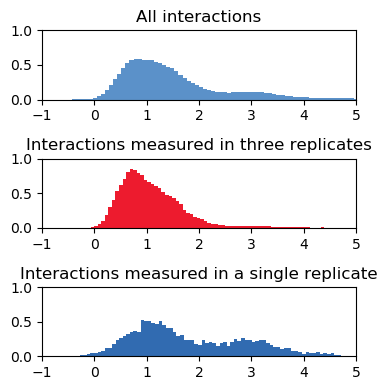

In [45]:
# Plotting affinity of interactions across entire dataset, those observed in 
# three replicates and those observed in one replicate

plt.rcParams.update({'font.size': 10})

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(4,4))
fig.subplots_adjust(hspace=0.5)

ax1.hist(df.aff_mean, density=True,bins=100,color='#5B91C9')
ax1.title.set_text('All interactions')
ax1.set_xlim([-1, 5])
ax1.set_ylim([0, 1])

ax2.hist(df[~((np.isnan(df[1])) | (np.isnan(df[2])) | (np.isnan(df[3])))].aff_mean, 
         density=True,bins=100,color='#ED1B2E')
ax2.title.set_text('Interactions measured in three replicates')
ax2.set_xlim([-1, 5])
ax2.set_ylim([0, 1])

ax3.hist(df[df[1].isna() & df[2].isna()].aff_mean, density=True,bins=100,color='#316BB1')
ax3.title.set_text('Interactions measured in a single replicate')
ax3.set_xlim([-1, 5])
ax3.set_ylim([0, 1])

plt.tight_layout()
plt.savefig('./figures/Interactions_distributions_epitope.png',dpi=300)
plt.show()
